# Exploratory analysis and generation of the user-videos interactions data

This notebook generates the final interactions data ready for modeling. The data is saved in a local .csv file and in S3 for further usage in creating the Personalize interactions dataset to drive Personalize recommendation models. it is worth mentioning that the digital videos data was taken from the Registry of Open Data on AWS: https://registry.opendata.aws/amazon-reviews/

<a id='contents' />

## Content Table

1. [Loading libraries and data](#loading)
2. [Data Exploration and cleaning](#analysis)
3. [Final data transformation and upload to S3](#dump)

<a id='loading' />

## Loading libraries and data
[(back to top)](#contents)

In [1]:
import numpy as np
import pandas as pd
import json
import datetime
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import boto3
import sagemaker
from sagemaker import get_execution_role
import seaborn as sns
import os
from collections import Counter

The following code defines the location of the digital video downloads data

In [2]:
role=get_execution_role()
bucket   = '<YOUR-BUCKER-NAME>'
prefix   = 'raw_data'
data_key = 'amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz'
data_location = 's3://{}/{}/{}'.format(bucket, prefix, data_key)

In [3]:
df=pd.read_csv(data_location, delimiter='\t', error_bad_lines=False, warn_bad_lines=False)
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


**Dataset general information:** Brief description of each column

|     Variable    |                    Description                   | 
|:--------------------:|:----------------------------------------------------------:|
marketplace|2-letter country code (in this case all "US").
customer_id|Random identifier that can be used to aggregate reviews written by a single author.
review_id|A unique ID for the review.
product_id|The Amazon Standard Identification Number (ASIN). Http://www.amazon.com/dp/ links to the product's detail page.
product_parent|The parent of that ASIN. Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
product_title|Title description of the product.
product_category|Broad product category that can be used to group reviews (in this case digital videos).
star_rating|The review's rating (1 to 5 stars).
helpful_votes|Number of helpful votes for the review.
total_votes|Number of total votes the review received.
vine|Was the review written as part of the Vine program?
verified_purchase|Was the review from a verified purchase?
review_headline|The title of the review itself.
review_body|The text of the review.
review_date|The date the review was written.

<a id='analysis' />

## Data exploration and cleaning
[(back to top)](#contents)

#### Number of records

In [4]:
#Number of records
len(df)

3998345

In [5]:
df.customer_id.nunique()

2018155

In [6]:
df.product_title.nunique()

90627

**Data types**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3998345 entries, 0 to 3998344
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   marketplace        object
 1   customer_id        int64 
 2   review_id          object
 3   product_id         object
 4   product_parent     int64 
 5   product_title      object
 6   product_category   object
 7   star_rating        int64 
 8   helpful_votes      int64 
 9   total_votes        int64 
 10  vine               object
 11  verified_purchase  object
 12  review_headline    object
 13  review_body        object
 14  review_date        object
dtypes: int64(5), object(10)
memory usage: 457.6+ MB


**Review date analysis**

Change review date type to datetime

In [8]:
df['review_date']=pd.to_datetime(df['review_date'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


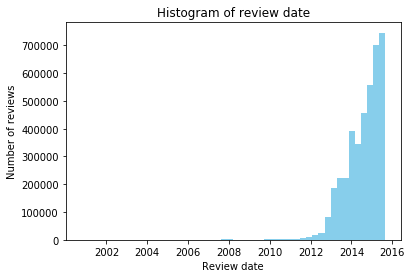

In [9]:
#Reviews by time
plt.hist(df['review_date'], 50, color = "skyblue")
title_string='Histogram of review date'
plt.xlabel('Review date')
plt.ylabel('Number of reviews')
plt.title(title_string)
plt.show()

In [10]:
#We will count reviews by year
df['year']=df.review_date.dt.year

In [11]:
df['review_date'].max()

Timestamp('2015-08-31 00:00:00')

In [12]:
df['year'].value_counts()

2015.0    1554812
2014.0    1543049
2013.0     721748
2012.0     142466
2011.0      20890
2010.0       6091
2009.0       3262
2008.0       3079
2007.0       2597
2006.0        185
2005.0         11
2004.0          6
2002.0          5
2003.0          4
2001.0          1
2000.0          1
Name: year, dtype: int64

**Years to include:** Just around 0.4% of the reviews were made before 2011, so for the model I just included data from 2011 and later.

In [15]:
len(df[df['year']>=2011])

3982965

In [16]:
#We will just consider the reviews from 2011 and later, for being more recent
df=df[df['year']>=2011]

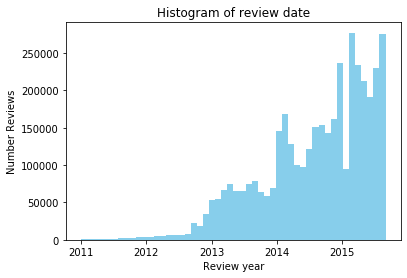

In [17]:
#Reviews by time
plt.figure()
plt.hist(df['review_date'], 50, color = "skyblue")
title_string='Histogram of review date'
plt.xlabel('Review year')
plt.ylabel('Number Reviews')
plt.title(title_string)
plt.show()

**Check for null values:**

In [18]:
df.isnull().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
review_headline      24
review_body          78
review_date           0
year                  0
dtype: int64

As we are not using the review headline and bosy, these null values do not affect the database

**Investigate product_id and product_title.** We will ensure that there are not duplicated reviews of the same product name

In [19]:
df.product_id.nunique()

163187

In [20]:
df['product_title']=df['product_title'].apply(lambda x: x.strip())
df.product_title.nunique()

88737

**Check for duplicates**

In [23]:
df[df.duplicated(['customer_id', 'product_title', 'review_date', 'star_rating', 'helpful_votes', 'total_votes', 'verified_purchase'])].head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year
3660,US,51253599,R2D58SFRNOLDYK,B00H7H4FK0,806333598,Smart Travels with Rudy Maxa,Digital_Video_Download,5,0,0,N,Y,A must see,Rudy Maxa brings real wit and charm to his spo...,2015-08-31,2015.0
8697,US,12195091,R3B73CZILFZ4FY,B00R8K7TEA,427320491,Fireman Sam,Digital_Video_Download,5,0,0,N,Y,Five Stars,grandkids love it!,2015-08-31,2015.0
10374,US,51253599,R35CG88O7JG35J,B00ERG9ANG,664427666,Smart Travels with Rudy Maxa,Digital_Video_Download,5,0,0,N,Y,A must see,Rudy Maxa brings real wit and charm to his spo...,2015-08-31,2015.0
17606,US,43430756,R3LO0JJYTKS1AC,B00ZJG6NQK,7832378,Z for Zachariah - Trailer,Digital_Video_Download,3,1,1,N,N,I COULD USE A GLASS OF WATER,Ann Burden (Margot Robbie) and her dog have ma...,2015-08-30,2015.0
17736,US,2732127,R3NGKS7HQUKT9E,B00MFDPY2Y,626478823,Fireman Sam,Digital_Video_Download,5,0,0,N,Y,Good!,Good!,2015-08-30,2015.0


We observe that the customer ID 51253599 did a review for Smart Travels with Rudy Maxa, that appears duplicated with two different profduct IDs. The same happens with customer ID 12195091, as shown below:

In [24]:
df[(df['customer_id']==12195091) & (df['product_title']=='Fireman Sam')]

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year
2526,US,12195091,R2H44FQCD69L9I,B00P8HULJ0,969493209,Fireman Sam,Digital_Video_Download,5,0,0,N,Y,Five Stars,grandkids love it!,2015-08-31,2015.0
8697,US,12195091,R3B73CZILFZ4FY,B00R8K7TEA,427320491,Fireman Sam,Digital_Video_Download,5,0,0,N,Y,Five Stars,grandkids love it!,2015-08-31,2015.0


There is a problem in the database: We are having duplicated reviews, because of changes in product IDs. We will remove the product ID column, and just keep the product title. 

In [25]:
df.drop(['product_id', 'product_parent'], axis=1, inplace=True)

Number of duplicated records:

In [26]:
len(df[df.duplicated([i for i in df.columns if i!='review_id'])])

149

Drop duplicated reviews:

In [27]:
df.drop_duplicates(subset=[i for i in df.columns if i!='review_id'], keep='last', inplace=True)

**Check for users with various reviews of same item**

In [28]:
df[df.duplicated(['customer_id', 'product_title'])].head()

,marketplace,customer_id,review_id,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year
12721,US,38294592,R3CRHUR6GF2GBN,Pokémon the Series: Ruby & Sapphire,Digital_Video_Download,5,1,1,N,Y,they love to watch and play at the same time,"My Boys are Pokémon crazy, they love to watch ...",2015-08-31,2015.0
34105,US,51859148,RB4F1IC2CJKZ8,Forensic Files,Digital_Video_Download,5,0,0,N,Y,True Crime Stories,I like all of the Forensic File series. These ...,2015-08-28,2015.0
48483,US,53082308,R1N0W0FJI10226,Forensic Files,Digital_Video_Download,5,0,0,N,Y,SEASON TWELVE CONTINUES THE EXCELLENCE,Season 12 continues the excellence of prior se...,2015-08-27,2015.0
54394,US,12612224,R1EOYMDY309H8R,Pokémon the Series: XY,Digital_Video_Download,5,1,1,N,Y,9 yo approved,9 yo approved. My son loves everything Pokémon.,2015-08-26,2015.0
57995,US,36899100,R2R7WLUD6CHTLW,Annie,Digital_Video_Download,5,1,1,N,Y,Annie,An excellent Classic.,2015-08-25,2015.0


Below we observe that customer ID 36899100 has two reviews for Annie, with different review bodies and headings, but the same star rating:

In [29]:
df[(df['customer_id']==36899100) & (df['product_title']=='Annie')]

,marketplace,customer_id,review_id,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year
57671,US,36899100,R9G7LC3J29L4C,Annie,Digital_Video_Download,5,0,1,N,Y,Annie,Annie is always excellent!,2015-08-25,2015.0
57995,US,36899100,R2R7WLUD6CHTLW,Annie,Digital_Video_Download,5,1,1,N,Y,Annie,An excellent Classic.,2015-08-25,2015.0


The same happens for customer ID 53082308 and the video Forensic Files, as shown below:

In [30]:
df[(df['customer_id']==53082308) & (df['product_title']=="Forensic Files")]

,marketplace,customer_id,review_id,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year
44926,US,53082308,R2TZYHAOC528U8,Forensic Files,Digital_Video_Download,5,0,0,N,Y,CAN'T GET ENOUGH FORENSIC FILES!,"Well this is the best of this genre, although ...",2015-08-27,2015.0
48483,US,53082308,R1N0W0FJI10226,Forensic Files,Digital_Video_Download,5,0,0,N,Y,SEASON TWELVE CONTINUES THE EXCELLENCE,Season 12 continues the excellence of prior se...,2015-08-27,2015.0


Number of repeated reviews to the same product:

In [31]:
len(df[df.duplicated(['customer_id', 'product_title'])])

10323

We also observe that there are user reviews of a single movie with different ratings.

In [32]:
#Convert data types
df['star_rating']=df['star_rating'].apply(pd.to_numeric)

In [33]:
df_sizes=df.groupby(['customer_id','product_title']).agg({'star_rating':['size','std']}).reset_index()
df_sizes.columns=['customer_id','product_title', 'size', 'std']

We calculated the standard deviation for the number of star ratings:

In [34]:
df_sizes[df_sizes['size']>1].sort_values('std', ascending=False)

,customer_id,product_title,size,std
3049903,43428083,Pilot,2,2.828427
3199069,45078621,Pilot,2,2.828427
942311,14394215,Pilot,2,2.828427
3778749,51692719,Pilot,2,2.828427
944156,14408896,Pilot,2,2.828427
...,...,...,...,...
2108703,28935030,Pilot,2,0.000000
2109442,28946058,Pilot,2,0.000000
2109892,28954262,The Naked Archaeologist,2,0.000000
2110028,28956502,Pilot,2,0.000000


Cases in which the star rating reviews for the same item were different:

In [35]:
len(df_sizes[(df_sizes['size']>1) & (df_sizes['std']>0)])

4025

In [36]:
del(df_sizes)

Below we observe an example of differences in ratings:

In [37]:
df[(df['customer_id']==16224346) & (df['product_title']=='Pilot')]

,marketplace,customer_id,review_id,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year
3519622,US,16224346,R2ZM7UUV0DX38E,Pilot,Digital_Video_Download,1,0,0,N,N,Disappointing,The pilot was just very badly made. The jokes ...,2013-06-09,2013.0
3519914,US,16224346,RTFZM09250N9K,Pilot,Digital_Video_Download,5,0,0,N,N,Great Show,Amazing. It would be a travesty if this is not...,2013-06-09,2013.0


 We choose to take the average of these ratings to aggregate them:

In [38]:
df=df.groupby(['customer_id','product_title']).agg({'review_date':['max'], 'star_rating':['mean'], 'helpful_votes':['sum'], 'total_votes':['sum'], 'verified_purchase':['max']}).reset_index()
df.columns=['customer_id','product_title', 'review_date', 'star_rating', 'helpful_votes', 'total_votes', 'verified_purchase']

**Exploration of helpful, total votes, star rating and verified purchase variable:**

In [40]:
vars_to_plot=['helpful_votes', 'total_votes', 'star_rating', 'verified_purchase']

In [41]:
def plot_histograms(dataframe, vars_to_plot):
    plt.figure(figsize=(14,10))
    for i, var in enumerate(vars_to_plot):
        plt.subplot(2,2,i+1)
        if var in ['helpful_votes', 'total_votes']:
            plt.hist(dataframe[var], 50, range=(0,50))
        else:
            plt.hist(dataframe[var], 50)
        title_string='Histogram of ' + var
        plt.xlabel(var)
        plt.ylabel('Count')
        plt.title(title_string)

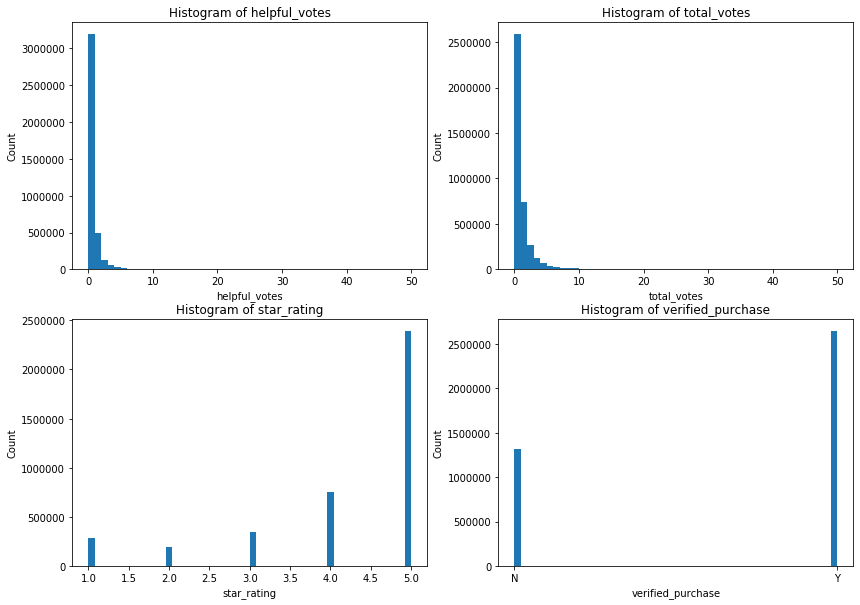

In [42]:
plot_histograms(df, vars_to_plot)

**Star rating analysis** 

In [43]:
df['star_rating'].describe()

count    3.972493e+06
mean     4.203664e+00
std      1.220808e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: star_rating, dtype: float64

In [44]:
#Count number of reviews for each star rating (from 1 to 5)
star_counts = Counter(df.star_rating)
tdf = pd.DataFrame.from_dict(star_counts, orient = 'index').sort_values(by = 0)
tdf = (tdf.iloc[-10:, :] / len(df)) * 100
# Sort dataframe by number of stars
tdf.sort_index(axis = 0, ascending = True, inplace = True)
tdf=tdf.loc[[1.0, 2.0, 3.0, 4.0, 5.0],:]

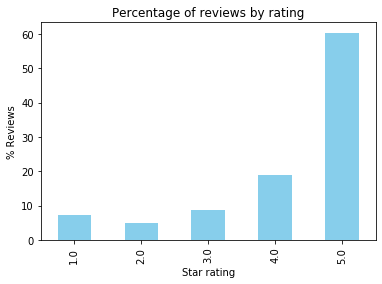

In [47]:
# Plot percent of reviews by star rating
ax = tdf.plot(kind = 'bar', color='skyblue')
ax.set_xlabel("Star rating")
ax.set_ylabel("% Reviews")
ax.set_title('Percentage of reviews by rating')
ax.legend_.remove()

plt.show()

The graph shown above presents the distribution of the star ratings, and we observe that the histogram is not uniform; there are few 1,2 and 3 ratings and a large cluster of 5 ratings; so we see that most people who review movies or TV shows do it positively. 

**Verfied purchase datatype**

In [48]:
#As this variable is string and categorical, we need to declare this in the interactions schema in the next notebook
df['verified_purchase'].value_counts()

Y    2650786
N    1321707
Name: verified_purchase, dtype: int64

**Exploration for customers and products:**

In [47]:
print("The number of users is", df.customer_id.unique().size)
print("The number of movies is", df.product_title.unique().size)

The number of users is 2010388
The number of movies is 88737


In [49]:
#Number of reviews by customer
customers = df.groupby('customer_id').size().reset_index(name="count_user")
#Number of reviews by product
products = df.groupby('product_title').size().reset_index(name="count_item")

In [106]:
quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.6, 0.75, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

**Number of products rated by each customer:**

We observe that there are on average approximately 1.98 reviews by customer:

In [50]:
customers.mean()

customer_id    2.753382e+07
count_user     1.975983e+00
dtype: float64

We also observe that just 5% of customers have rated 5 or more videos. This is expected as people usually rate fewer videos than they actually see, so we expected our data to be sparse.

In [61]:
#Customers quantiles
customers['count_user'].quantile(quantiles)

0.00       1.0
0.01       1.0
0.02       1.0
0.03       1.0
0.04       1.0
0.05       1.0
0.10       1.0
0.25       1.0
0.50       1.0
0.75       2.0
0.80       2.0
0.90       4.0
0.95       5.0
0.96       6.0
0.97       7.0
0.98       9.0
0.99      13.0
1.00    2646.0
Name: count_user, dtype: float64

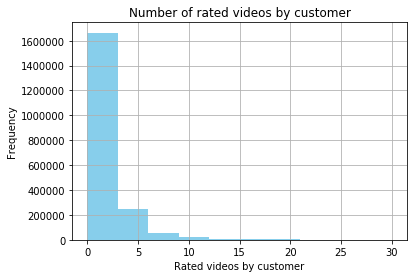

In [104]:
df.groupby('customer_id')['product_title'].count().hist(range=(0,30), color='skyblue')
plt.title('Number of rated videos by customer')
#plt.ticklabel_format(axis='y', style='sci', scilimits=(3,0))
plt.xlabel('Rated videos by customer')
plt.ylabel('Frequency')
plt.show()

**Number of reviews by video:**

On the other hand, the average of reviews by video is of 44.77:

In [51]:
products.mean()

count_item    44.767042
dtype: float64

In [52]:
products.describe()

,count_item
count,88737.000000
mean,44.767042
std,407.110442
min,1.000000
25%,1.000000
50%,3.000000
75%,12.000000
max,51881.000000


We observe that 60% of the videos have been rated by 5 or more users:

In [107]:
#Products quantiles:
products['count_item'].quantile(quantiles)

0.00        1.00
0.01        1.00
0.02        1.00
0.03        1.00
0.04        1.00
0.05        1.00
0.10        1.00
0.25        1.00
0.50        3.00
0.60        5.00
0.75       12.00
0.80       18.00
0.90       50.00
0.95      128.00
0.96      169.00
0.97      241.92
0.98      385.00
0.99      770.00
1.00    51881.00
Name: count_item, dtype: float64

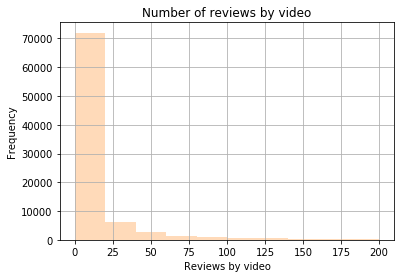

In [105]:
df.groupby('product_title')['customer_id'].count().hist(range=(0,200), color='peachpuff')
plt.title('Number of reviews by video')
plt.xlabel('Reviews by video')
plt.ylabel('Frequency')
plt.show()

<a id='dump' />

## Final Data Transformation and Upload to S3
[(back to top)](#loading)

Create a timestamp variable

In [48]:
df['timestamp']=df['review_date'].apply(lambda x: x.timestamp()).astype(int)

Define needed columns

In [49]:
df=df[['customer_id', 'product_title', 'timestamp', 'star_rating', 'verified_purchase']]
df.columns=['USER_ID', 'ITEM_ID', 'TIMESTAMP', 'EVENT_RATING', 'EVENT_VERIFIED_PURCHASE']

In [50]:
df['EVENT_TYPE']='RATING'

Look again at duplicated values:

In [52]:
df[df.duplicated()]

,USER_ID,ITEM_ID,TIMESTAMP,EVENT_RATING,EVENT_VERIFIED_PURCHASE,EVENT_TYPE


Final format:

In [55]:
df.head()

,USER_ID,ITEM_ID,TIMESTAMP,EVENT_RATING,EVENT_VERIFIED_PURCHASE,EVENT_TYPE
0,10013,Spring Breakers,1386288000,1.0,N,RATING
1,10018,Stardust,1397001600,4.0,N,RATING
2,10022,Space Buddies,1368144000,5.0,Y,RATING
3,10030,Kindergarten Cop,1413849600,5.0,Y,RATING
4,10030,Sleepless In Seattle,1420329600,5.0,N,RATING


### Display overall statistics

In [57]:
epi_stats = pd.DataFrame(df['ITEM_ID'].value_counts()).describe()
epu_stats = pd.DataFrame(df['USER_ID'].value_counts()).describe()

In [58]:
item_count = df['ITEM_ID'].nunique()
user_count = df['USER_ID'].nunique()
interaction_count = df.shape[0]

print('{:,} items\n{:,} users\n{:,} interactions'.format(item_count, 
                                                                user_count, 
                                                                interaction_count))

print('reviews per item    (median/mean/stdev) {:.2f}/{:.2f}/{:.2f}'.format(epi_stats.loc['mean'].values[0],
                                                                           epi_stats.loc['50%'].values[0],
                                                                           epi_stats.loc['std'].values[0]))
print('reviews per user    (median/mean/stdev) {:.2f}/{:.2f}/{:.2f}'.format(epu_stats.loc['mean'].values[0],
                                                                           epu_stats.loc['50%'].values[0],
                                                                           epu_stats.loc['std'].values[0]))

77,535 items
1,513,569 users
2,828,960 interactions
reviews per item    (median/mean/stdev) 36.49/3.00/322.38
reviews per user    (median/mean/stdev) 1.87/1.00/3.34


### Save data to S3 and expanded interactions to local csv

In [59]:
bucket='checkride-mfcs-aiml'
prefix='tidy_data'
interactions_filename = 'movies-interactions.csv'

In [60]:
df.to_csv(interactions_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}'.format(prefix, interactions_filename)).upload_file(interactions_filename)